<a href="https://colab.research.google.com/github/talhaanwarch/Plant-Leaf-Disease-Classification/blob/master/transfer_learning_interdomain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### download data

### install efficinetnet model

In [1]:
!pip install efficientnet

In [2]:
!wget https://data.mendeley.com/datasets/3f83gxmv57/2/files/53398b67-6f0e-4a67-8384-e2b574b2ebf4/Citrus.zip

--2020-03-31 13:01:35--  https://data.mendeley.com/datasets/3f83gxmv57/2/files/53398b67-6f0e-4a67-8384-e2b574b2ebf4/Citrus.zip
Resolving data.mendeley.com (data.mendeley.com)... 162.159.130.86, 162.159.133.86, 2606:4700:7::a29f:8256, ...
Connecting to data.mendeley.com (data.mendeley.com)|162.159.130.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/ad404a4d-cedf-4830-8a11-0fc204ce8acb [following]
--2020-03-31 13:01:37--  https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/ad404a4d-cedf-4830-8a11-0fc204ce8acb
Resolving md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)... 52.218.101.216
Connecting to md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)|52.218.101.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66977095 (64

### unzip donwloaded dataset

In [3]:
!unzip /content/Citrus.zip

Archive:  /content/Citrus.zip
   creating: Citrus/
   creating: Citrus/Fruits/
   creating: Citrus/Fruits/Black spot/
  inflating: Citrus/Fruits/Black spot/Black spot (1).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (10).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (11).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (12).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (13).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (14).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (15).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (16).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (17).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (18).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (19).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (2).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (3).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (4).jpg  
  inflating: Citrus/Fruits/Black spot/Black sp

## import libraries

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt


In [0]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPool2D, BatchNormalization,Input,MaxPooling2D,GlobalMaxPooling2D,concatenate
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf

## data augmentation 

In [0]:
from keras_preprocessing.image import ImageDataGenerator

data_gen= ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=360,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=.1,
    rescale=1/255,
    fill_mode='nearest',
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    validation_split=0.3)

In [0]:
img_shape=300
batch_size=16

# Leaves

In [8]:
#load the training data
leaves_train_generator = data_gen.flow_from_directory(
    '/content/Citrus/Leaves',
    target_size=(img_shape,img_shape),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True)


Found 429 images belonging to 5 classes.


In [9]:
#load the training data
val_suffle=False
leaves_val_generator = data_gen.flow_from_directory(
    '/content/Citrus/Leaves',
    target_size=(img_shape,img_shape),
    batch_size=16,
    class_mode='categorical',
    subset='validation',shuffle=val_suffle)#shuffle should be False in validation
    #https://stackoverflow.com/a/47439789/11170350


Found 180 images belonging to 5 classes.


In [10]:
leaves_train_generator.next()[0].shape,leaves_train_generator.next()[1].shape

((16, 300, 300, 3), (16, 5))

In [11]:
leaves_val_generator.next()[0].shape,leaves_val_generator.next()[1].shape

((16, 300, 300, 3), (16, 5))

### Base model

In [12]:
import efficientnet.tfkeras as efn
leaves_model =efn.EfficientNetB4(weights ='noisy-student', include_top=False, input_shape = (img_shape,img_shape,3))


71680000/71678424 [==============================] - 7s 0us/step


In [0]:
x = leaves_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
predictions = Dense(5, activation="softmax")(x)

In [0]:
leaves_model = Model(inputs=leaves_model.input, outputs=predictions)

In [0]:
def custom_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.1)

In [0]:
leaves_model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

In [17]:

trainable_count = np.sum([K.count_params(w) for w in leaves_model.trainable_weights])
non_trainable_count = np.sum([K.count_params(w) for w in leaves_model.non_trainable_weights])

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 17,911,901
Trainable params: 17,786,701
Non-trainable params: 125,200


In [18]:
results = leaves_model.fit(leaves_train_generator,epochs=15,
                              steps_per_epoch=leaves_train_generator.n/batch_size,
                              validation_data=leaves_val_generator,
                             validation_steps=leaves_val_generator.n/batch_size,
                              callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=2, min_lr=0.000001)])

Epoch 1/15
27/26 [==============================] - 46s 2s/step - loss: 1.1147 - accuracy: 0.6597 - val_loss: 2.4889 - val_accuracy: 0.5611 - lr: 0.0010
Epoch 2/15
27/26 [==============================] - 40s 1s/step - loss: 0.8214 - accuracy: 0.7995 - val_loss: 1.5331 - val_accuracy: 0.6611 - lr: 0.0010
Epoch 3/15
27/26 [==============================] - 40s 1s/step - loss: 0.7256 - accuracy: 0.8788 - val_loss: 1.4047 - val_accuracy: 0.6222 - lr: 0.0010
Epoch 4/15
27/26 [==============================] - 40s 1s/step - loss: 0.6583 - accuracy: 0.9044 - val_loss: 1.5266 - val_accuracy: 0.5778 - lr: 0.0010
Epoch 5/15
27/26 [==============================] - 40s 1s/step - loss: 0.6183 - accuracy: 0.9114 - val_loss: 1.0185 - val_accuracy: 0.6778 - lr: 0.0010
Epoch 6/15
27/26 [==============================] - 40s 1s/step - loss: 0.6077 - accuracy: 0.9091 - val_loss: 1.4767 - val_accuracy: 0.5944 - lr: 0.0010
Epoch 7/15
27/26 [==============================] - 41s 2s/step - loss: 0.6766 - a

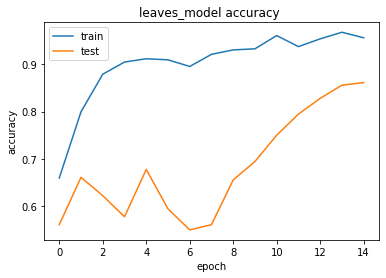

In [19]:

plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('leaves_model accuracy ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

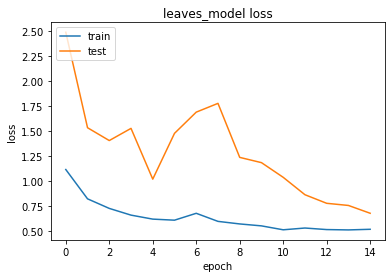

In [20]:

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('leaves_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
leaves_model.evaluate(leaves_val_generator,steps=leaves_val_generator.n//batch_size)

11/11 [==============================] - 5s 441ms/step - loss: 0.7317 - accuracy: 0.8659


[0.731717050075531, 0.8658536672592163]

In [22]:
leaves_val_generator.reset()
leaves_model.evaluate(leaves_val_generator,steps=leaves_val_generator.n//batch_size)

11/11 [==============================] - 5s 445ms/step - loss: 0.7425 - accuracy: 0.8693


[0.7424865365028381, 0.8693181872367859]

In [23]:
leaves_val_generator.reset()
y_pred=leaves_model.predict(leaves_val_generator,steps=leaves_val_generator.n/batch_size,verbose=1)

12/11 [================================] - 5s 439ms/step


In [0]:
if val_suffle==True:
  per = np.random.permutation(leaves_val_generator.n)
  leaves_val_generator.index_array = per
  y_true = leaves_val_generator.classes[per]
else: 
  y_true = leaves_val_generator.classes

In [0]:
y_pred=np.argmax(y_pred, axis=1)

In [26]:
y_pred.shape,y_true.shape

((180,), (180,))

In [27]:
from sklearn.metrics import classification_report,accuracy_score,f1_score
print(accuracy_score(y_true,y_pred))
print(f1_score(y_true,y_pred,average='macro'))

0.8611111111111112
0.8899299110664003


In [28]:
class_label=list(leaves_train_generator.class_indices.keys())
print(classification_report(y_true, y_pred,target_names=class_label))#

              precision    recall  f1-score   support

  Black spot       0.85      0.88      0.87        51
    Melanose       1.00      1.00      1.00         3
      canker       0.95      0.81      0.88        48
    greening       0.84      0.84      0.84        61
     healthy       0.77      1.00      0.87        17

    accuracy                           0.86       180
   macro avg       0.88      0.91      0.89       180
weighted avg       0.87      0.86      0.86       180



In [0]:
leaves_model.save('leave_model.h5')

# Fruit

In [30]:
#load the training data
fruits_train_generator = data_gen.flow_from_directory(
    '/content/Citrus/Fruits',
    target_size=(img_shape,img_shape),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True)


Found 108 images belonging to 5 classes.


In [31]:
#load the training data
val_suffle=False
fruits_val_generator = data_gen.flow_from_directory(
    '/content/Citrus/Fruits',
    target_size=(img_shape,img_shape),
    batch_size=16,
    class_mode='categorical',
    subset='validation',shuffle=val_suffle)#shuffle should be False in validation
    #https://stackoverflow.com/a/47439789/11170350


Found 42 images belonging to 5 classes.


In [32]:
fruits_train_generator.next()[0].shape,fruits_train_generator.next()[1].shape

((16, 300, 300, 3), (16, 5))

In [33]:
fruits_val_generator.next()[0].shape,fruits_val_generator.next()[1].shape

((16, 300, 300, 3), (16, 5))

### Base model

In [0]:
import efficientnet.tfkeras as efn
fruit_model =efn.EfficientNetB4(weights ='noisy-student', include_top=False, input_shape = (img_shape,img_shape,3))


In [0]:
x = fruit_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
predictions = Dense(5, activation="softmax")(x)

In [0]:
fruit_model = Model(inputs=fruit_model.input, outputs=predictions)

In [0]:
def custom_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.1)

In [0]:
fruit_model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

In [39]:

trainable_count = np.sum([K.count_params(w) for w in fruit_model.trainable_weights])
non_trainable_count = np.sum([K.count_params(w) for w in fruit_model.non_trainable_weights])

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 17,911,901
Trainable params: 17,786,701
Non-trainable params: 125,200


In [40]:
results = fruit_model.fit(fruits_train_generator,epochs=15,
                              steps_per_epoch=fruits_train_generator.n/batch_size,
                              validation_data=fruits_val_generator,
                             validation_steps=fruits_val_generator.n/batch_size,
                              callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=2, min_lr=0.000001)])

Epoch 1/15
7/6 [===============================] - 15s 2s/step - loss: 1.3274 - accuracy: 0.5463 - val_loss: 1.6208 - val_accuracy: 0.5476 - lr: 0.0010
Epoch 2/15
7/6 [===============================] - 9s 1s/step - loss: 1.0999 - accuracy: 0.6389 - val_loss: 1.5531 - val_accuracy: 0.4286 - lr: 0.0010
Epoch 3/15
7/6 [===============================] - 9s 1s/step - loss: 1.0279 - accuracy: 0.7037 - val_loss: 1.4135 - val_accuracy: 0.6429 - lr: 0.0010
Epoch 4/15
7/6 [===============================] - 9s 1s/step - loss: 0.8611 - accuracy: 0.7315 - val_loss: 1.5431 - val_accuracy: 0.5714 - lr: 0.0010
Epoch 5/15
7/6 [===============================] - 9s 1s/step - loss: 0.7852 - accuracy: 0.8241 - val_loss: 1.7870 - val_accuracy: 0.5476 - lr: 0.0010
Epoch 6/15
7/6 [===============================] - 9s 1s/step - loss: 0.7803 - accuracy: 0.8333 - val_loss: 1.8015 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 7/15
7/6 [===============================] - 9s 1s/step - loss: 0.7106 - accuracy: 

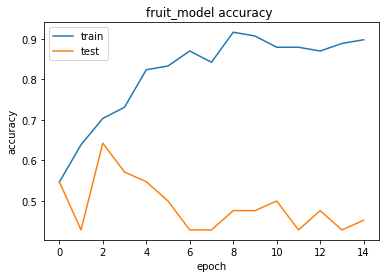

In [41]:

plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('fruit_model accuracy ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

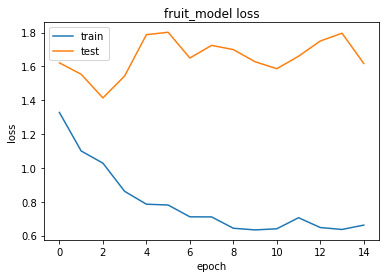

In [42]:

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('fruit_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [43]:
fruit_model.evaluate(fruits_val_generator,steps=fruits_val_generator.n//batch_size)

2/2 [==============================] - 1s 289ms/step - loss: 2.1654 - accuracy: 0.2308


[2.1653928756713867, 0.23076923191547394]

In [44]:
fruits_val_generator.reset()
fruit_model.evaluate(fruits_val_generator,steps=fruits_val_generator.n//batch_size)

2/2 [==============================] - 1s 288ms/step - loss: 1.2420 - accuracy: 0.5625


[1.2420334815979004, 0.5625]

In [45]:
fruits_val_generator.reset()
y_pred=fruit_model.predict(fruits_val_generator,steps=fruits_val_generator.n/batch_size,verbose=1)

3/2 [==================================] - 1s 267ms/step


In [0]:
if val_suffle==True:
  per = np.random.permutation(fruits_val_generator.n)
  fruits_val_generator.index_array = per
  y_true = fruits_val_generator.classes[per]
else: 
  y_true = fruits_val_generator.classes

In [0]:
y_pred=np.argmax(y_pred, axis=1)

In [48]:
y_pred.shape,y_true.shape

((42,), (42,))

In [49]:
from sklearn.metrics import classification_report,accuracy_score,f1_score
print(accuracy_score(y_true,y_pred))
print(f1_score(y_true,y_pred,average='macro'))

0.5238095238095238
0.5336625086625086


In [50]:
class_label=list(fruits_train_generator.class_indices.keys())
print(classification_report(y_true, y_pred,target_names=class_label))#

              precision    recall  f1-score   support

  Black spot       0.50      0.80      0.62         5
      Canker       0.79      0.48      0.59        23
    Greening       0.50      1.00      0.67         4
        Scab       1.00      0.50      0.67         4
     healthy       0.10      0.17      0.12         6

    accuracy                           0.52        42
   macro avg       0.58      0.59      0.53        42
weighted avg       0.65      0.52      0.54        42



# Model Transfer
Leave model to Fruit model

In [0]:
import efficientnet.tfkeras as efn
leave2fruit =efn.EfficientNetB4(weights =None, include_top=False, input_shape = (img_shape,img_shape,3))


In [0]:
x = leave2fruit.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
predictions = Dense(5, activation="softmax")(x)

In [0]:
leave2fruit = Model(inputs=leave2fruit.input, outputs=predictions)

In [0]:
def custom_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.1)

In [0]:
leave2fruit.compile(optimizer=Adam(0.0001), loss=custom_loss, metrics=['accuracy'])

In [0]:
leave2fruit.load_weights('leave_model.h5')

In [59]:

trainable_count = np.sum([K.count_params(w) for w in leave2fruit.trainable_weights])
non_trainable_count = np.sum([K.count_params(w) for w in leave2fruit.non_trainable_weights])

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 17,911,901
Trainable params: 17,786,701
Non-trainable params: 125,200


In [60]:
results = leave2fruit.fit(fruits_train_generator,epochs=15,
                              steps_per_epoch=fruits_train_generator.n/batch_size,
                              validation_data=fruits_val_generator,
                             validation_steps=fruits_val_generator.n/batch_size,
                              callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.000001)])

Epoch 1/15
7/6 [===============================] - 12s 2s/step - loss: 2.7474 - accuracy: 0.0648 - val_loss: 2.0169 - val_accuracy: 0.5714 - lr: 1.0000e-04
Epoch 2/15
7/6 [===============================] - 9s 1s/step - loss: 2.0704 - accuracy: 0.1944 - val_loss: 1.7821 - val_accuracy: 0.6190 - lr: 1.0000e-04
Epoch 3/15
7/6 [===============================] - 9s 1s/step - loss: 1.8640 - accuracy: 0.1481 - val_loss: 1.6557 - val_accuracy: 0.5952 - lr: 1.0000e-04
Epoch 4/15
7/6 [===============================] - 9s 1s/step - loss: 1.6417 - accuracy: 0.2500 - val_loss: 1.6079 - val_accuracy: 0.5714 - lr: 1.0000e-04
Epoch 5/15
7/6 [===============================] - 9s 1s/step - loss: 1.5100 - accuracy: 0.3333 - val_loss: 1.5373 - val_accuracy: 0.5952 - lr: 1.0000e-04
Epoch 6/15
7/6 [===============================] - 9s 1s/step - loss: 1.4623 - accuracy: 0.3241 - val_loss: 1.4261 - val_accuracy: 0.6667 - lr: 1.0000e-04
Epoch 7/15
7/6 [===============================] - 9s 1s/step - loss:

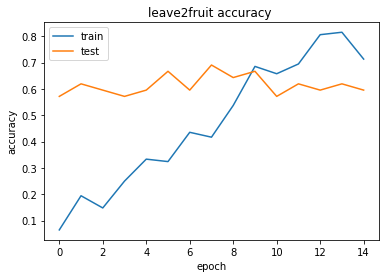

In [61]:

plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('leave2fruit accuracy ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

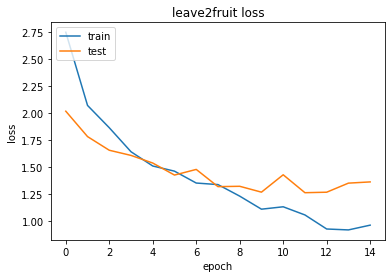

In [62]:

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('leave2fruit loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [63]:
leave2fruit.evaluate(fruits_val_generator,steps=fruits_val_generator.n//batch_size)

2/2 [==============================] - 0s 135ms/step - loss: 1.2540 - accuracy: 0.6923


[1.2539618015289307, 0.692307710647583]

In [64]:
fruits_val_generator.reset()
leave2fruit.evaluate(fruits_val_generator,steps=fruits_val_generator.n//batch_size)

2/2 [==============================] - 0s 244ms/step - loss: 0.9793 - accuracy: 0.6562


[0.9792776107788086, 0.65625]

In [65]:
fruits_val_generator.reset()
y_pred=leave2fruit.predict(fruits_val_generator,steps=fruits_val_generator.n/batch_size,verbose=1)

3/2 [==================================] - 1s 263ms/step


In [0]:
if val_suffle==True:
  per = np.random.permutation(fruits_val_generator.n)
  fruits_val_generator.index_array = per
  y_true = fruits_val_generator.classes[per]
else: 
  y_true = fruits_val_generator.classes

In [0]:
y_pred=np.argmax(y_pred, axis=1)

In [68]:
y_pred.shape,y_true.shape

((42,), (42,))

In [69]:
from sklearn.metrics import classification_report,accuracy_score,f1_score
print(accuracy_score(y_true,y_pred))
print(f1_score(y_true,y_pred,average='macro'))

0.5714285714285714
0.33427672955974835


In [70]:
class_label=list(fruits_train_generator.class_indices.keys())
print(classification_report(y_true, y_pred,target_names=class_label))#

              precision    recall  f1-score   support

  Black spot       0.00      0.00      0.00         5
      Canker       0.67      0.87      0.75        23
    Greening       0.25      0.25      0.25         4
        Scab       0.40      0.50      0.44         4
     healthy       0.33      0.17      0.22         6

    accuracy                           0.57        42
   macro avg       0.33      0.36      0.33        42
weighted avg       0.47      0.57      0.51        42



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Fine tuning
Leave model to Fruit model

In [0]:
import efficientnet.tfkeras as efn
leave2fruit =efn.EfficientNetB4(weights =None, include_top=False, input_shape = (img_shape,img_shape,3))
x = leave2fruit.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
predictions = Dense(5, activation="softmax")(x)

In [0]:
leave2fruit = Model(inputs=leave2fruit.input, outputs=predictions)
leave2fruit.compile(optimizer=Adam(0.0001), loss=custom_loss, metrics=['accuracy'])
leave2fruit.load_weights('leave_model.h5')

In [0]:
for layer in leave2fruit.layers[:-6]:
    layer.trainable = False

In [74]:
results = leave2fruit.fit(fruits_train_generator,epochs=15,
                              steps_per_epoch=fruits_train_generator.n/batch_size,
                              validation_data=fruits_val_generator,
                             validation_steps=fruits_val_generator.n/batch_size,
                              callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.000001)])

Epoch 1/15
7/6 [===============================] - 12s 2s/step - loss: 2.4942 - accuracy: 0.1481 - val_loss: 1.9375 - val_accuracy: 0.5714 - lr: 1.0000e-04
Epoch 2/15
7/6 [===============================] - 9s 1s/step - loss: 2.1617 - accuracy: 0.0926 - val_loss: 1.7119 - val_accuracy: 0.5476 - lr: 1.0000e-04
Epoch 3/15
7/6 [===============================] - 9s 1s/step - loss: 1.9007 - accuracy: 0.1204 - val_loss: 1.5866 - val_accuracy: 0.5714 - lr: 1.0000e-04
Epoch 4/15
7/6 [===============================] - 9s 1s/step - loss: 1.6724 - accuracy: 0.2037 - val_loss: 1.6360 - val_accuracy: 0.5476 - lr: 1.0000e-04
Epoch 5/15
7/6 [===============================] - 9s 1s/step - loss: 1.6167 - accuracy: 0.2407 - val_loss: 1.4473 - val_accuracy: 0.6429 - lr: 1.0000e-04
Epoch 6/15
7/6 [===============================] - 9s 1s/step - loss: 1.4384 - accuracy: 0.3426 - val_loss: 1.4806 - val_accuracy: 0.5952 - lr: 1.0000e-04
Epoch 7/15
7/6 [===============================] - 9s 1s/step - loss:

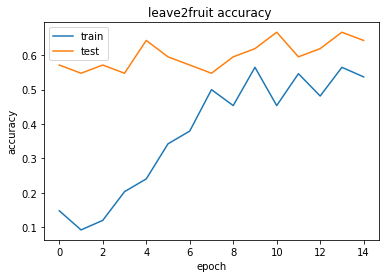

In [75]:

plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('leave2fruit accuracy ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

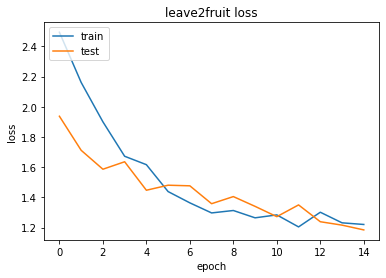

In [76]:

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('leave2fruit loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [77]:
fruits_val_generator.reset()
leave2fruit.evaluate(fruits_val_generator,steps=fruits_val_generator.n//batch_size)

2/2 [==============================] - 1s 281ms/step - loss: 0.9649 - accuracy: 0.7188


[0.9649451375007629, 0.71875]

In [78]:
fruits_val_generator.reset()
leave2fruit.evaluate(fruits_val_generator,steps=fruits_val_generator.n//batch_size)

2/2 [==============================] - 1s 276ms/step - loss: 0.9379 - accuracy: 0.7500


[0.9378787279129028, 0.75]

In [79]:
fruits_val_generator.reset()
y_pred=leave2fruit.predict(fruits_val_generator,steps=fruits_val_generator.n/batch_size,verbose=1)

3/2 [==================================] - 1s 275ms/step


In [0]:
if val_suffle==True:
  per = np.random.permutation(fruits_val_generator.n)
  fruits_val_generator.index_array = per
  y_true = fruits_val_generator.classes[per]
else: 
  y_true = fruits_val_generator.classes

In [0]:
y_pred=np.argmax(y_pred, axis=1)

In [82]:
y_pred.shape,y_true.shape

((42,), (42,))

In [83]:
from sklearn.metrics import classification_report,accuracy_score,f1_score
print(accuracy_score(y_true,y_pred))
print(f1_score(y_true,y_pred,average='macro'))

0.5714285714285714
0.34522911051212934


In [84]:
class_label=list(fruits_train_generator.class_indices.keys())
print(classification_report(y_true, y_pred,target_names=class_label))#

              precision    recall  f1-score   support

  Black spot       0.00      0.00      0.00         5
      Canker       0.67      0.87      0.75        23
    Greening       0.33      0.50      0.40         4
        Scab       0.67      0.50      0.57         4
     healthy       0.00      0.00      0.00         6

    accuracy                           0.57        42
   macro avg       0.33      0.37      0.35        42
weighted avg       0.46      0.57      0.51        42

